<a href="https://colab.research.google.com/github/HieuVuong001/AQI_analysis/blob/main/ProjectCode_CMPE255.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Before you begin


1.   Use the [Cloud Resource Manager](https://console.cloud.google.com/cloud-resource-manager) to Create a Cloud Platform project if you do not already have one.
2.   [Enable billing](https://support.google.com/cloud/answer/6293499#enable-billing) for the project.
3.   [Enable BigQuery](https://console.cloud.google.com/flows/enableapi?apiid=bigquery) APIs for the project.


### Import Library

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import os
import folium
from folium.plugins import HeatMap
from google.cloud import bigquery
from google.colab import auth

### Provide your Google Cloud credentials to the runtime

In [2]:
auth.authenticate_user()
print('Authenticated')

Authenticated


## Optional: Enable data table display

Colab includes the ``google.colab.data_table`` package that can be used to display large pandas dataframes as an interactive data table.
It can be enabled with:

In [3]:
%load_ext google.colab.data_table

If you would prefer to return to the classic Pandas dataframe display, you can disable this by running:
```python
%unload_ext google.colab.data_table
```

Declare the Cloud project ID which will be used throughout this notebook

In [4]:
project_id = 'cmpe255-project-419122'

In [5]:
!gcloud config list

[component_manager]
disable_update_check = True
[core]
account = kwanqing.ong@sjsu.edu

Your active configuration is: [default]


In [6]:
#!gcloud config set compute/region us-central1
#!gcloud config set compute/zone us-central1-a
!gcloud config list project

[core]
project (unset)

Your active configuration is: [default]


In [7]:
!gcloud config set project 'cmpe255-project-419122'

Updated property [core/project].


In [8]:
!gcloud config list project

[core]
project = cmpe255-project-419122

Your active configuration is: [default]


In [9]:
# https://cloud.google.com/resource-manager/docs/creating-managing-projects
project_id = 'cmpe255-project-419122'
client = bigquery.Client(project=project_id)

#Print your current data
for dataset in client.list_datasets():
  print(dataset.dataset_id)

aqi_trend_analysis_dataset


## AQI Trend Analysis Dataset


## Data Processing

In [ ]:
# # Path to the directory where all your CSV files are stored
# csv_directory = '/content/'

# # List to hold data from each CSV
# dataframes_list = []

# # Loop through all the CSV files in the directory
# for filename in os.listdir(csv_directory):
#     if filename.endswith('.csv'):
#         # Construct the full file path
#         filepath = os.path.join(csv_directory, filename)
#         # Read the CSV file and append it to the list
#         df = pd.read_csv(filepath)
#         dataframes_list.append(df)

# # Concatenate all DataFrames in the list into one
# annual_aqi_by_county_df = pd.concat(dataframes_list, ignore_index=True)

# # Optionally, you can save the merged DataFrame to a new CSV file
# annual_aqi_by_county_df.to_csv('/content/annual_aqi_by_county.csv', index=False)

# # Display the shape of the merged DataFrame to confirm
# print(f"Merged DataFrame shape: {annual_aqi_by_county_df.shape}")

# annual_aqi_by_county_df.head()

Merged DataFrame shape: (11176, 18)


,State,County,Year,Days with AQI,Good Days,Moderate Days,Unhealthy for Sensitive Groups Days,Unhealthy Days,Very Unhealthy Days,Hazardous Days,Max AQI,90th Percentile AQI,Median AQI,Days CO,Days NO2,Days Ozone,Days PM2.5,Days PM10
0,Alabama,Baldwin,2016,279,247,32,0,0,0,0,87,51,37,0,0,221,58,0
1,Alabama,Clay,2016,116,109,7,0,0,0,0,56,45,30,0,0,0,116,0
2,Alabama,Colbert,2016,282,258,23,1,0,0,0,115,50,38,0,0,219,63,0
3,Alabama,DeKalb,2016,348,304,43,1,0,0,0,119,54,40,0,0,321,27,0
4,Alabama,Elmore,2016,117,107,10,0,0,0,0,77,48,40,0,0,117,0,0


In [ ]:
# # Rename columns to comply with BigQuery's column naming conventions
# annual_aqi_by_county_df = annual_aqi_by_county_df.rename(columns={
#     'Days PM2.5': 'Days_PM2_5',
# })

# # Save preprocessed data to big query
# annual_aqi_by_county_df.to_gbq(
#     'cmpe255-project-419122.aqi_trend_analysis_dataset.annual_aqi_by_county_df',
#     project_id='cmpe255-project-419122',
#     if_exists='replace',
#     progress_bar=True
# )

100%|██████████| 1/1 [00:00<00:00, 8542.37it/s]


## Exploratory Data Analysis (EDA)

In [10]:
sql = """
SELECT
    *
FROM
    `cmpe255-project-419122.aqi_trend_analysis_dataset.annual_aqi_by_county_df`
ORDER BY
  Year, State, County
"""
dfquery = client.query(sql)

In [11]:
annual_aqi_by_county_df=dfquery.to_dataframe()
annual_aqi_by_county_df.head()

,State,County,Year,Days with AQI,Good Days,Moderate Days,Unhealthy for Sensitive Groups Days,Unhealthy Days,Very Unhealthy Days,Hazardous Days,Max AQI,90th Percentile AQI,Median AQI,Days CO,Days NO2,Days Ozone,Days_PM2_5,Days PM10
0,Alabama,Baldwin,2013,273,235,38,0,0,0,0,87,54,36,0,0,200,73,0
1,Alabama,Clay,2013,118,100,18,0,0,0,0,65,52,32,0,0,0,118,0
2,Alabama,Colbert,2013,285,252,33,0,0,0,0,80,51,38,0,0,202,83,0
3,Alabama,DeKalb,2013,360,319,41,0,0,0,0,93,52,38,0,0,305,55,0
4,Alabama,Elmore,2013,244,229,15,0,0,0,0,87,48,36,0,0,244,0,0


In [12]:
annual_aqi_by_county_df.tail()

,State,County,Year,Days with AQI,Good Days,Moderate Days,Unhealthy for Sensitive Groups Days,Unhealthy Days,Very Unhealthy Days,Hazardous Days,Max AQI,90th Percentile AQI,Median AQI,Days CO,Days NO2,Days Ozone,Days_PM2_5,Days PM10
11171,Wyoming,Sublette,2023,211,92,113,6,0,0,0,122,84,54,0,0,209,2,0
11172,Wyoming,Sweetwater,2023,212,125,78,8,0,1,0,211,87,49,0,0,170,33,9
11173,Wyoming,Teton,2023,244,203,41,0,0,0,0,74,54,46,1,0,240,3,0
11174,Wyoming,Uinta,2023,181,181,0,0,0,0,0,32,12,6,0,0,0,0,181
11175,Wyoming,Weston,2023,181,154,27,0,0,0,0,90,58,44,0,0,181,0,0


In [13]:
annual_aqi_by_county_df.shape

(11176, 18)

In [14]:
# Information about the DataFrame
annual_aqi_by_county_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11176 entries, 0 to 11175
Data columns (total 18 columns):
 #   Column                               Non-Null Count  Dtype 
---  ------                               --------------  ----- 
 0   State                                11176 non-null  object
 1   County                               11176 non-null  object
 2   Year                                 11176 non-null  Int64 
 3   Days with AQI                        11176 non-null  Int64 
 4   Good Days                            11176 non-null  Int64 
 5   Moderate Days                        11176 non-null  Int64 
 6   Unhealthy for Sensitive Groups Days  11176 non-null  Int64 
 7   Unhealthy Days                       11176 non-null  Int64 
 8   Very Unhealthy Days                  11176 non-null  Int64 
 9   Hazardous Days                       11176 non-null  Int64 
 10  Max AQI                              11176 non-null  Int64 
 11  90th Percentile AQI                  1117

In [15]:
# Summary statistics
annual_aqi_by_county_df.describe()

,Year,Days with AQI,Good Days,Moderate Days,Unhealthy for Sensitive Groups Days,Unhealthy Days,Very Unhealthy Days,Hazardous Days,Max AQI,90th Percentile AQI,Median AQI,Days CO,Days NO2,Days Ozone,Days_PM2_5,Days PM10
count,11176.0,11176.0,11176.0,11176.0,11176.0,11176.0,11176.0,11176.0,11176.0,11176.0,11176.0,11176.0,11176.0,11176.0,11176.0,11176.0
mean,2017.928239,305.679581,246.808608,54.822119,3.167144,0.730315,0.096099,0.055297,120.862115,57.351646,36.396743,0.683339,4.982015,173.512885,114.524964,11.976378
std,3.150519,87.575589,80.36493,45.526172,8.587467,3.32113,1.180406,0.699749,140.471024,17.300197,10.210863,10.400905,22.52437,117.864987,109.02719,48.47553
min,2013.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,8.0,6.0,1.0,0.0,0.0,0.0,0.0,0.0
25%,2015.0,245.0,197.0,21.0,0.0,0.0,0.0,0.0,87.0,49.0,33.0,0.0,0.0,81.75,0.0,0.0
50%,2018.0,360.0,267.0,43.0,1.0,0.0,0.0,0.0,105.0,55.0,38.0,0.0,0.0,192.0,102.0,0.0
75%,2021.0,365.0,312.0,78.0,3.0,0.0,0.0,0.0,133.0,64.0,42.0,0.0,0.0,246.0,179.0,0.0
max,2023.0,366.0,365.0,339.0,122.0,69.0,74.0,31.0,7577.0,542.0,122.0,358.0,365.0,366.0,366.0,366.0


In [16]:
# Check for duplicate rows
print(f"Duplicate rows: {annual_aqi_by_county_df.duplicated().sum()}")

# # Remove duplicate rows
# df_no_duplicates = df_sfcrime.drop_duplicates()

Duplicate rows: 0


In [17]:
# Check for missing values
missing_values = annual_aqi_by_county_df.isnull().sum()
missing_values

State                                  0
County                                 0
Year                                   0
Days with AQI                          0
Good Days                              0
Moderate Days                          0
Unhealthy for Sensitive Groups Days    0
Unhealthy Days                         0
Very Unhealthy Days                    0
Hazardous Days                         0
Max AQI                                0
90th Percentile AQI                    0
Median AQI                             0
Days CO                                0
Days NO2                               0
Days Ozone                             0
Days_PM2_5                             0
Days PM10                              0
dtype: int64

In [20]:
# Finding distinct years
distinct_years = annual_aqi_by_county_df['Year'].unique()

# Sorting the years in ascending order (since .unique() returns a numpy array, you can use np.sort())
distinct_years_sorted = np.sort(distinct_years)

# Display the sorted unique years
print(distinct_years_sorted)

[2013 2014 2015 2016 2017 2018 2019 2020 2021 2022 2023]


In [ ]:
annual_aqi_by_county_df['State'].unique()

array(['Alabama', 'Alaska', 'Arizona', 'Arkansas', 'California',
       'Colorado', 'Connecticut', 'Country Of Mexico', 'Delaware',
       'District Of Columbia', 'Florida', 'Georgia', 'Hawaii', 'Idaho',
       'Illinois', 'Indiana', 'Iowa', 'Kansas', 'Kentucky', 'Louisiana',
       'Maine', 'Maryland', 'Massachusetts', 'Michigan', 'Minnesota',
       'Mississippi', 'Missouri', 'Montana', 'Nebraska', 'Nevada',
       'New Hampshire', 'New Jersey', 'New Mexico', 'New York',
       'North Carolina', 'North Dakota', 'Ohio', 'Oklahoma', 'Oregon',
       'Pennsylvania', 'Puerto Rico', 'Rhode Island', 'South Carolina',
       'South Dakota', 'Tennessee', 'Texas', 'Utah', 'Vermont',
       'Virgin Islands', 'Virginia', 'Washington', 'West Virginia',
       'Wisconsin', 'Wyoming'], dtype=object)

In [ ]:
annual_aqi_by_county_df['County'].unique()

array(['Baldwin', 'Clay', 'Colbert', 'DeKalb', 'Elmore', 'Etowah',
       'Houston', 'Jefferson', 'Lawrence', 'Madison', 'Mobile',
       'Montgomery', 'Morgan', 'Russell', 'Shelby', 'Sumter', 'Talladega',
       'Tuscaloosa', 'Aleutians East ', 'Anchorage ', 'Denali ',
       'Fairbanks North Star ', 'Juneau ', 'Kenai Peninsula ',
       'Matanuska-Susitna ', 'Yukon-Koyukuk ', 'Apache', 'Cochise',
       'Coconino', 'Gila', 'La Paz', 'Maricopa', 'Mohave', 'Navajo',
       'Pima', 'Pinal', 'Santa Cruz', 'Yavapai', 'Yuma', 'Arkansas',
       'Ashley', 'Clark', 'Crittenden', 'Garland', 'Jackson', 'Newton',
       'Polk', 'Pulaski', 'Union', 'Washington', 'Alameda', 'Alpine',
       'Amador', 'Butte', 'Calaveras', 'Colusa', 'Contra Costa',
       'Del Norte', 'El Dorado', 'Fresno', 'Glenn', 'Humboldt',
       'Imperial', 'Inyo', 'Kern', 'Kings', 'Lake', 'Los Angeles',
       'Madera', 'Marin', 'Mariposa', 'Mendocino', 'Merced', 'Mono',
       'Monterey', 'Napa', 'Nevada', 'Orange', 'Place

## Visualization

Trend Analysis:

How has the air quality index (AQI) changed over the years in specific counties or states?
Are there any noticeable seasonal patterns in air pollution levels?

Pollutant-Specific Analysis:

Which pollutants have the highest concentrations in the dataset, and how do these levels vary across different locations?
For pollutants like PM2.5 and ozone, what are the trends over time, and how do they correlate with public health advisories?

Geographical Comparisons:

Which counties or regions have consistently shown the best and worst air quality over the years?
How do urban versus rural areas compare in terms of air quality and types of pollutants?

Impact of Environmental Policies:

Can any improvements in air quality be correlated with the implementation of specific environmental policies or regulations?
How do emission reduction programs or initiatives like tree planting campaigns affect local air quality?

Public Health Correlations:

Is there a correlation between poor air quality days and hospital admissions for respiratory conditions?
How does the exposure to different levels of pollutants affect vulnerable populations, such as children and the elderly?

Meteorological Influence:

How do meteorological conditions (temperature, humidity, wind speed) influence air quality and pollutant dispersion?
Are there any clear correlations between air quality and specific weather patterns or climate conditions?

Forecasting:

Can we predict future air quality levels based on historical trends, meteorological data, and current pollution levels?
What role do natural events like wildfires or volcanic eruptions play in affecting air quality forecasts?
Socioeconomic Factors:

Are there socioeconomic factors, such as industry presence or vehicle density, that significantly impact air quality in specific areas?
How does air quality correlate with population density and urban development?

### Question 1: How has the air quality index (AQI) changed over the years in specific counties or states?


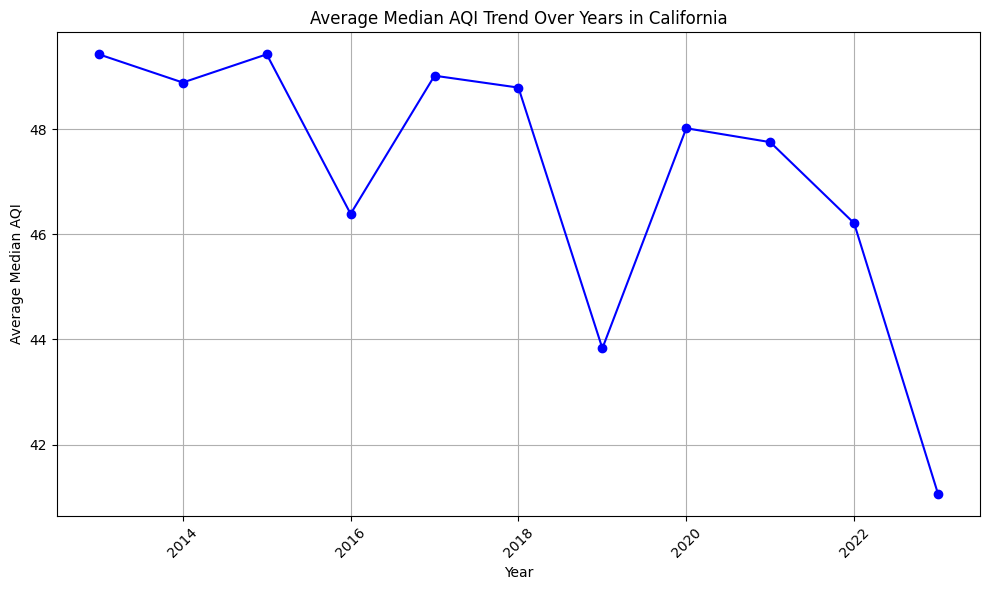

In [ ]:
# Filtering the dataset for a specific state (Replace 'California' with your state of interest)
selected_state = 'California'
state_specific_data = annual_aqi_by_county_df[annual_aqi_by_county_df['State'] == selected_state]

# Grouping the data by 'Year' and calculating the average of 'Median AQI'
annual_aqi_trend = state_specific_data.groupby('Year')['Median AQI'].mean().reset_index()

# Plotting the trend
plt.figure(figsize=(10, 6))
plt.plot(annual_aqi_trend['Year'], annual_aqi_trend['Median AQI'], marker='o', linestyle='-', color='blue')
plt.title(f'Average Median AQI Trend Over Years in {selected_state}')
plt.xlabel('Year')
plt.ylabel('Average Median AQI')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

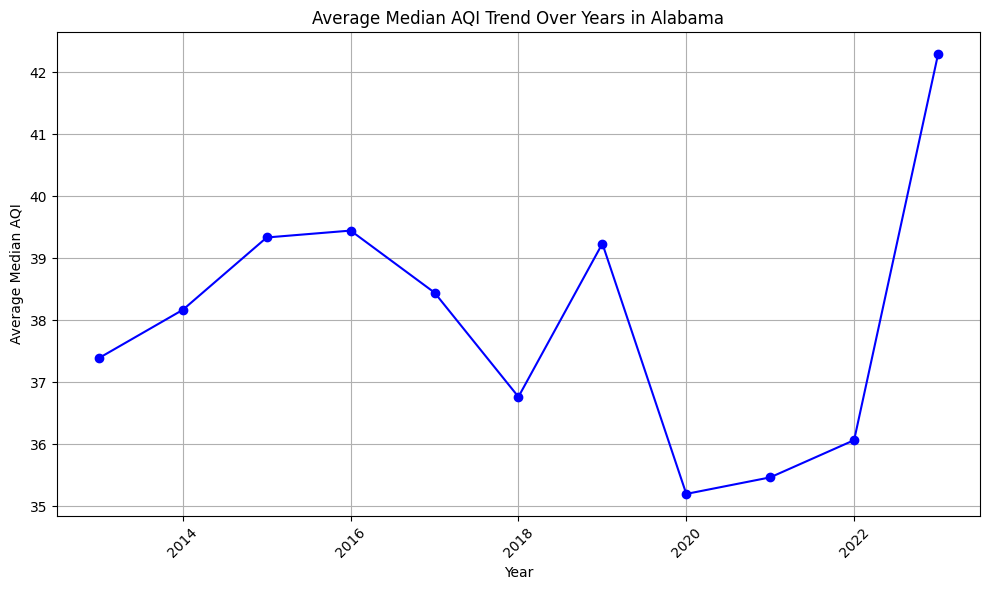

In [ ]:
# Filtering the dataset for a specific state (Try different States)
selected_state = 'Alabama'
state_specific_data = annual_aqi_by_county_df[annual_aqi_by_county_df['State'] == selected_state]

# Grouping the data by 'Year' and calculating the average of 'Median AQI'
annual_aqi_trend = state_specific_data.groupby('Year')['Median AQI'].mean().reset_index()

# Plotting the trend
plt.figure(figsize=(10, 6))
plt.plot(annual_aqi_trend['Year'], annual_aqi_trend['Median AQI'], marker='o', linestyle='-', color='blue')
plt.title(f'Average Median AQI Trend Over Years in {selected_state}')
plt.xlabel('Year')
plt.ylabel('Average Median AQI')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

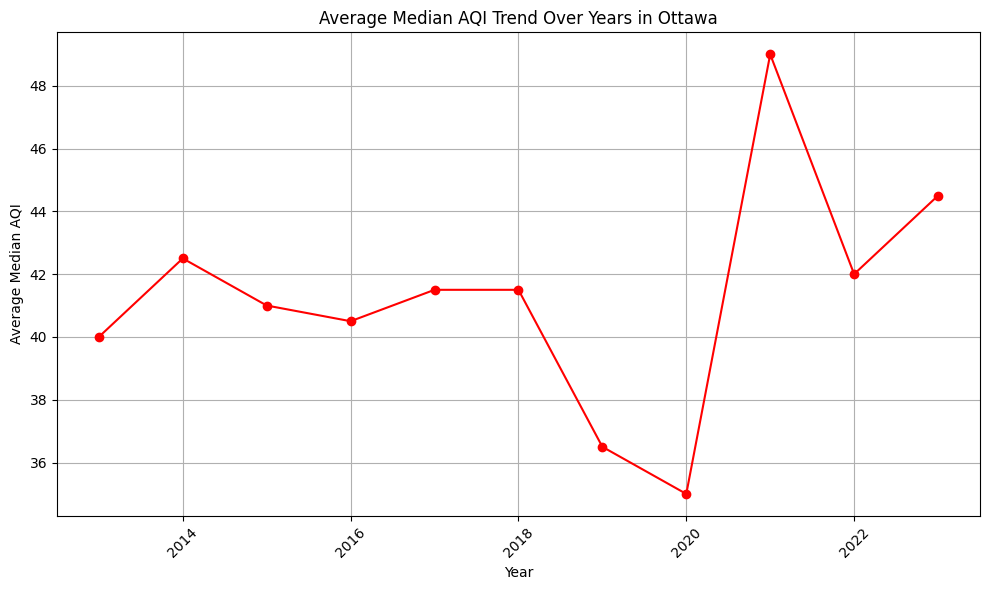

In [ ]:
# Filtering the dataset for a specific county (Replace 'Ottawa' with your county of interest)
selected_county = 'Ottawa'
state_specific_data = annual_aqi_by_county_df[annual_aqi_by_county_df['County'] == selected_county]

# Grouping the data by 'Year' and calculating the average of 'Median AQI'
annual_aqi_trend = state_specific_data.groupby('Year')['Median AQI'].mean().reset_index()

# Plotting the trend
plt.figure(figsize=(10, 6))
plt.plot(annual_aqi_trend['Year'], annual_aqi_trend['Median AQI'], marker='o', linestyle='-', color='red')
plt.title(f'Average Median AQI Trend Over Years in {selected_county}')
plt.xlabel('Year')
plt.ylabel('Average Median AQI')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [ ]:
# SQL query to calculate the average Median AQI for each year for a specific state.
q1 = """
SELECT
  Year,
  AVG(`Median AQI`) AS Average_Median_AQI
FROM
  `cmpe255-project-419122.aqi_trend_analysis_dataset.annual_aqi_by_county_df`
WHERE
  State = 'California'
GROUP BY
  Year
ORDER BY
  Year;
"""

df_q1=client.query(q1).to_dataframe()
df_q1.head(100)

,Year,Average_Median_AQI
0,2013,49.425926
1,2014,48.888889
2,2015,49.425926
3,2016,46.388889
4,2017,49.018868
5,2018,48.792453
6,2019,43.830189
7,2020,48.018868
8,2021,47.754717
9,2022,46.211538


In [ ]:
# SQL query to calculate the average Median AQI for each year for a specific county.
q2 = """
SELECT
  Year,
  AVG(`Median AQI`) AS Average_Median_AQI
FROM
  `cmpe255-project-419122.aqi_trend_analysis_dataset.annual_aqi_by_county_df`
WHERE
  County = 'Ottawa'
GROUP BY
  Year
ORDER BY
  Year;
"""

df_q2=client.query(q2).to_dataframe()
df_q2.head(100)

,Year,Average_Median_AQI
0,2013,40.0
1,2014,42.5
2,2015,41.0
3,2016,40.5
4,2017,41.5
5,2018,41.5
6,2019,36.5
7,2020,35.0
8,2021,49.0
9,2022,42.0


### Question 2: How have the levels of PM2.5 and ozone changed over the years?

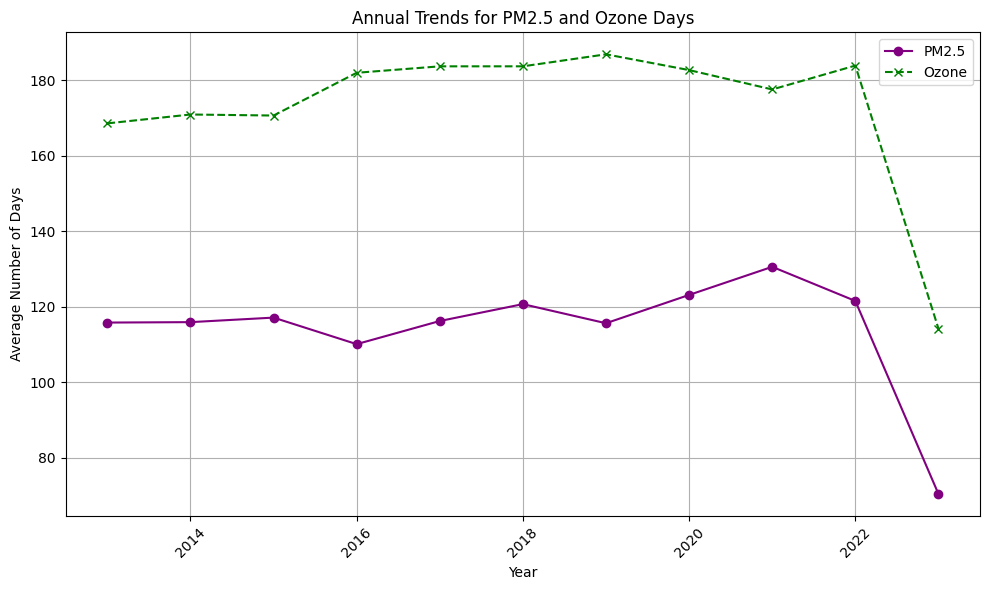

In [23]:
# Calculate the average number of days per year that PM2.5 and ozone were the predominant pollutants across all locations
# Aggregate the data
annual_trends = annual_aqi_by_county_df.groupby('Year').agg({
    'Days_PM2_5': 'mean',
    'Days Ozone': 'mean'
}).reset_index()

plt.figure(figsize=(10, 6))

# Plot PM2.5 trends
plt.plot(annual_trends['Year'], annual_trends['Days_PM2_5'], label='PM2.5', marker='o', linestyle='-', color='purple')

# Plot Ozone trends
plt.plot(annual_trends['Year'], annual_trends['Days Ozone'], label='Ozone', marker='x', linestyle='--', color='green')

plt.title('Annual Trends for PM2.5 and Ozone Days')
plt.xlabel('Year')
plt.ylabel('Average Number of Days')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [24]:
# SQL query to calculate the annual average number of days that PM2.5 was the predominant pollutants.
q3 = """
SELECT
  Year,
  AVG(`Days_PM2_5`) AS Avg_Days_PM2_5
FROM
  `cmpe255-project-419122.aqi_trend_analysis_dataset.annual_aqi_by_county_df`
GROUP BY
  Year
ORDER BY
  Year;
"""

df_q3=client.query(q3).to_dataframe()
df_q3.head(100)

,Year,Avg_Days_PM2_5
0,2013,115.812261
1,2014,115.924710
2,2015,117.126679
3,2016,110.095146
4,2017,116.221574
5,2018,120.699314
6,2019,115.636275
7,2020,123.134596
8,2021,130.583832
9,2022,121.543000


In [25]:
# SQL query to calculate the annual average number of days that ozone was the predominant pollutants.
q4 = """
SELECT
  Year,
  AVG(`Days Ozone`) AS Avg_Days_Ozone
FROM
  `cmpe255-project-419122.aqi_trend_analysis_dataset.annual_aqi_by_county_df`
GROUP BY
  Year
ORDER BY
  Year;
"""

df_q4=client.query(q4).to_dataframe()
df_q4.head(100)

,Year,Avg_Days_Ozone
0,2013,168.596743
1,2014,170.947876
2,2015,170.674664
3,2016,182.003883
4,2017,183.711370
5,2018,183.717924
6,2019,186.898039
7,2020,182.717846
8,2021,177.585828
9,2022,183.912000
